# Getting Started with KerasHub

**Author:** [Matthew Watson](https://github.com/mattdangerw/), [Jonathan Bischof](https://github.com/jbischof)<br>
**Date created:** 2022/12/15<br>
**Last modified:** 2024/10/17<br>
**Description:** An introduction to the KerasHub API.

**KerasHub** is a pretrained modeling library that aims to be simple, flexible, and fast.
The library provides [Keras 3](https://keras.io/keras_3/) implementations of popular
model architectures, paired with a collection of pretrained checkpoints available on
[Kaggle](https://www.kaggle.com/organizations/keras/models). Models can be used for both
training and inference on any of the TensorFlow, Jax, and Torch backends.

KerasHub is an extension of the core Keras API; KerasHub components are provided as
`keras.Layer`s and `keras.Model`s. If you are familiar with Keras, congratulations! You
already understand most of KerasHub.

This guide is meant to be an accessible introduction to the entire library. We will start
by using high-level APIs to classify images and generate text, then progressively show
deeper customization of models and training. Throughout the guide, we use Professor Keras,
the official Keras mascot, as a visual reference for the complexity of the material:

![](https://storage.googleapis.com/keras-nlp/getting_started_guide/prof_keras_evolution.png)

As always, we'll keep our Keras guides focused on real-world code examples. You can play
with the code here at any time by clicking the Colab link at the top of the guide.

## Installation and Setup

To begin, let's install keras-hub. The library is available on PyPI, so we can simply
install it with pip.

In [19]:
!pip install --upgrade --quiet keras-hub-nightly keras-nightly

Keras 3 was built to work on top of TensorFlow, Jax, and Torch backends. You should
specify the backend first thing when writing Keras code, before any library imports. We
will use the Jax backend for this guide, but you can use `torch` or `tensorflow` without
changing a single line in the rest of this guide. That's the power of Keras 3!

We will also set `XLA_PYTHON_CLIENT_MEM_FRACTION`, which frees up the whole GPU for
Jax to use from the start.

In [20]:
import os

os.environ["KERAS_BACKEND"] = "jax"  # or "tensorflow" or "torch"
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "1.0"

Lastly, we need to do some extra setup to access the models used in this guide. Many
popular open LLMs, such as Gemma from Google and Llama from Meta, require accepting
a community license before accessing the model weights. We will be using Gemma in this
guide, so we can follow the following steps:

1. Go to the [Gemma 2](https://www.kaggle.com/models/keras/gemma2) model page, and accept
   the license at the banner at the top.
2. Generate an Kaggle API key by going to [Kaggle settings](https://www.kaggle.com/settings)
   and clicking "Create New Token" button under the "API" section.
3. Inside your colab notebook, click on the key icon on the left hand toolbar. Add two
   secrets: `KAGGLE_USERNAME` with your username, and `KAGGLE_KEY` with the API key you just
   created. Make these secrets visible to the notebook you are running.

## API Quickstart

Before we begin, let's take a look at the key classes we will use in the KerasHub library.

* **Task**: e.g., `keras_hub.models.CausalLM`, `keras_hub.models.ImageClassifier`, and
`keras_hub.models.TextClassifier`.
  * **What it does**: A task maps from raw image, audio, and text inputs to model
    predictions.
  * **Why it's important**: A task is the highest-level entry point to the KerasHub API. It
    encapsulates both preprocessing and modeling into a single, easy-to-use class. Tasks can
    be used both for fine-tuning and inference.
  * **Has a**: `backbone` and `preprocessor`.
  * **Inherits from**: `keras.Model`.
* **Backbone**: `keras_hub.models.Backbone`.
  * **What it does**: Maps preprocessed tensor inputs to the latent space of the model.
  * **Why it's important**: The backbone encapsulates the architecture and parameters of a
    pretrained models in a way that is unspecialized to any particular task. A backbone can
    be combined with arbitrary preprocessing and "head" layers mapping dense features to
    predictions to accomplish any ML task.
  * **Inherits from**: `keras.Model`.
* **Preprocessor**: e.g.,`keras_hub.models.CausalLMPreprocessor`,
  `keras_hub.models.ImageClassifierPreprocessor`, and
  `keras_hub.models.TextClassifierPreprocessor`.
  * **What it does**: A preprocessor maps from raw image, audio and text inputs to
    preprocessed tensor inputs.
  * **Why it's important**: A preprocessing layer encapsulates all tasks specific
    preprocessing, e.g. image resizing and text tokenization, in a way that can be used
    standalone to precompute preprocessed inputs. Note that if you are using a high-level
    task class, this preprocessing is already baked in by default.
  * **Has a**: `tokenizer`, `audio_converter`, and/or `image_converter`.
  * **Inherits from**: `keras.layers.Layer`.
* **Tokenizer**: `keras_hub.tokenizers.Tokenizer`.
  * **What it does**: Converts strings to sequences of token ids.
  * **Why it's important**: The raw bytes of a string are an inefficient representation of
    text input, so we first map string inputs to integer token ids. This class encapsulated
    the mapping of strings to ints and the reverse (via the `detokenize()` method).
  * **Inherits from**: `keras.layers.Layer`.
* **ImageConverter**: `keras_hub.layers.ImageConverter`.
  * **What it does**: Resizes and rescales image input.
  * **Why it's important**: Image models often need to normalize image inputs to a specific
    range, or resizing inputs to a specific size. This class encapsulates the image-specific
    preprocessing.
  * **Inherits from**: `keras.layers.Layer`.
* **AudioConveter**: `keras_hub.layers.AudioConveter`.
  * **What it does**: Converts raw audio to model ready input.
  * **Why it's important**: Audio models often need to preprocess raw audio input before
    passing it to a model, e.g. by computing a spectrogram of the audio signal. This class
    encapsulates the image specific preprocessing in an easy to use layer.
  * **Inherits from**: `keras.layers.Layer`.

All of the classes listed here have a `from_preset()` constructor, which will instantiate
the component with weights and state for the given pre-trained model identifier. E.g.
`keras_hub.tokenizers.Tokenizer.from_preset("gemma2_2b_en")` will create a layer that
tokenizes text using a Gemma2 tokenizer vocabulary.

The figure below shows how all these core classes interact. Arrow indicate composition
not inheritance (e.g., a task *has a* backbone).

![png](/img/guides/getting_started/class-diagram.png)

## Classify an image

![](https://storage.googleapis.com/keras-nlp/getting_started_guide/prof_keras_beginner.png)

Enough setup! Let's have some fun with pre-trained models. Let's load a test image of a
California Quail and classify it.

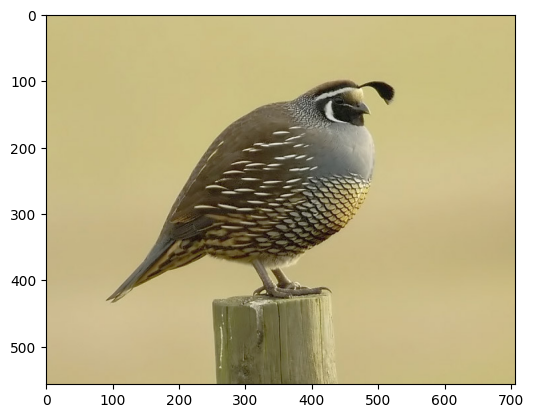

In [21]:
import keras
import numpy as np
import matplotlib.pyplot as plt

image_url = "https://upload.wikimedia.org/wikipedia/commons/a/aa/California_quail.jpg"
image_path = keras.utils.get_file(origin=image_url)
image = keras.utils.load_img(image_path)
plt.imshow(image)

We can use a ResNet vision model trained on the ImageNet-1k database. This model will
give each input sample and output label from `[0, 1000)`, where each label corresponds to
some real word entity, like a "milk can" or a "porcupine." The dataset actually has a
specific label for quail, at index 85. Let's download the model and predict a label.

In [22]:
import keras_hub

image_classifier = keras_hub.models.ImageClassifier.from_preset(
    "resnet_50_imagenet",
    activation="softmax",
)
batch = np.array([image])
image_classifier.preprocessor.image_size = (224, 224)
preds = image_classifier.predict(batch)
preds.shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


(1, 1000)

These ImageNet labels aren't a particularly "human readable," so we can use a built-in
utility function to decode the predictions to a set of class names.

In [23]:
keras_hub.utils.decode_imagenet_predictions(preds)

[[('quail', 0.9996539354324341),
  ('prairie_chicken', 8.488613093504682e-05),
  ('partridge', 1.4027125871507451e-05),
  ('black_grouse', 7.4539716479193885e-06),
  ('bullet_train', 7.276947599166306e-06)]]

Looking good! The model weights successfully downloaded, and we predicted the
correct classification label for our quail image with near certainty.

This was our first example of the high-level **task** API mentioned in the API quickstart
above. An `keras_hub.models.ImageClassifier` is a task for classifying images, and can be
used with a number of different model architectures (ResNet, VGG, MobileNet, etc). You
can view the full list of models shipped directly by the Keras team on
[Kaggle](https://www.kaggle.com/organizations/keras/models).

A task is just a subclass of `keras.Model` — you can use `fit()`, `compile()`, and
`save()` on our `classifier` object same as any other model. But tasks come with a few
extras provided by the KerasHub library. The first and most important is `from_preset()`,
a special constructor you will see on many classes in KerasHub.

A **preset** is a directory of model state. It defines both the architecture we should
load and the pretrained weights that go with it. `from_preset()` allows us to load
**preset** directories from a number of different locations:

- A local directory.
- The Kaggle Model hub.
- The HuggingFace model hub.

You can take a look at the `keras_hub.models.ImageClassifier.from_preset` docs to better
understand all the options when constructing a Keras model from a preset.

All tasks use two main sub-objects. A `keras_hub.models.Backbone` and a
`keras_hub.layers.Preprocessor`. You might be familiar already with the term **backbone**
from computer vision, where it is often used to describe a feature extractor network that
maps images to a latent space. A KerasHub backbone is this concept generalized, we use it
to refer to any pretrained model without a task-specific head. That is, a KerasHub
backbone maps raw images, audio and text (or a combination of these inputs) to a
pretrained model's latent space. We can then map this latent space to any number of task
specific outputs, depending on what we are trying to do with the model.

A **preprocessor** is just a Keras layer that does all the preprocessing for a specific
task. In our case, preprocessing with will resize our input image and rescale it to the
range `[0, 1]` using some ImageNet specific mean and variance data. Let's call our
task's preprocessor and backbone in succession to see what happens to our input shape.

In [24]:
print("Raw input shape:", batch.shape)
resized_batch = image_classifier.preprocessor(batch)
print("Preprocessed input shape:", resized_batch.shape)
hidden_states = image_classifier.backbone(resized_batch)
print("Latent space shape:", hidden_states.shape)

Raw input shape: (1, 557, 707, 3)
Preprocessed input shape: (1, 224, 224, 3)
Latent space shape: (1, 7, 7, 2048)


Our raw image is rescaled to `(224, 224)` during preprocessing and finally
downscaled to a `(7, 7)` image of 2048 feature vectors — the latent space of the
ResNet model. Note that ResNet can actually handle images of arbitrary sizes,
though performance will eventually fall off if your image is very different
sized than the pretrained data. If you'd like to disable the resizing in the
preprocessing layer, you can run `image_classifier.preprocessor.image_size = None`.

If you are ever wondering the exact structure of the task you loaded, you can
use `model.summary()` same as any Keras model. The model summary for tasks will
included extra information on model preprocessing.

In [25]:
image_classifier.summary()

Preprocessor: "res_net_image_classifier_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ res_net_image_converter (ResNetImageConverter)                │                   Image size: (224, 224) │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "res_net_image_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                  ┃ Output Shape                       ┃             Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)                    │ (None, None, None, 3)              │                   0 │
├───────────────────────────────────────────────┼────────────────────────────────────┼─────────────────────┤
│ res_net_backbone (ResNetBackbone)             │ (None, None, None, 2048)           │          23,561,152 │
├───────────────────────────────────────────────┼────────────────────────────────────┼─────────────────────┤
│ pooler (GlobalAveragePooling2D)               │ (None, 2048)                       │                   0 │
├───────────────────────────────────────────────┼────────────────────────────────────┼─────────────────────┤
│ output_dropout (Dropout)                      │ (None, 2048)                       │                   0 │
├───────────────────────────────────────────────┼────────────────────────────────────┼─────────────────────┤
│ predictions (Dense)                           │ (None, 1000)                       │           2,049,000 │
└───────────────────────────────────────────────┴────────────────────────────────────┴─────────────────────┘

 Total params: 25,610,152 (97.69 MB)

 Trainable params: 25,557,032 (97.49 MB)

 Non-trainable params: 53,120 (207.50 KB)

## Generate text with an LLM

![](https://storage.googleapis.com/keras-nlp/getting_started_guide/prof_keras_intermediate.png)

Next up, let's try working with and generating text. The task we can use when generating
text is `keras_hub.models.CausalLM` (where LM is short for **L**anguage **M**odel). Let's
download the 2 billion parameter Gemma 2 model and try it out.

Since this is about 100x larger model than the ResNet model we just downloaded, we need to be
a little more careful about our GPU memory usage. We can use a half-precision type to
load each parameter of our ~2.5 billion as a two-byte float instead of four. To do this
we can pass `dtype` to the `from_preset()` constructor. `from_preset()` will forward any
kwargs to the main constructor for the class, so you can pass kwargs that work on all
Keras layers like `dtype`, `trainable`, and `name`.

In [26]:
causal_lm = keras_hub.models.CausalLM.from_preset(
    "gemma2_instruct_2b_en",
    dtype="bfloat16",
)

The model we just loaded was an instruction-tuned version of Gemma, which means the model
was further fine-tuned for chat. We can take advantage of these capabilities as long as
we stick to the particular template for text used when training the model. These special
tokens vary per model and can be hard to track, the [Kaggle model
page](https://www.kaggle.com/models/keras/gemma2/) will contain details such as this.

`CausalLM` come with an extra function called `generate()` which can be used generate
predict tokens in a loop and decode them as a string.

In [27]:
template = "<start_of_turn>user\n{question}<end_of_turn>\n<start_of_turn>model"

question = """Write a python program to generate the first 1000 prime numbers.
Just show the actual code."""
print(causal_lm.generate(template.format(question=question), max_length=512))

<start_of_turn>user
Write a python program to generate the first 1000 prime numbers.
Just show the actual code.<end_of_turn>
<start_of_turn>model```python
def is_prime(n):
  if n <= 1:
    return False
  for i in range(2, int(n**0.5) + 1):
    if n % i == 0:
      return False
  return True

count = 0
number = 2
primes = []
while count < 1000:
  if is_prime(number):
    primes.append(number)
    count += 1
  number += 1
print(primes)
``` 
<end_of_turn>


Note that on the Jax and TensorFlow backends, this `generate()` function is compiled, so
the second time you call for the same `max_length`, it will actually be much faster.
KerasHub will use Jax an TensorFlow to compute an optimized version of the generation
computational graph that can be reused.

In [28]:
question = "Share a very simple brownie recipe."
print(causal_lm.generate(template.format(question=question), max_length=512))

<start_of_turn>user
Share a very simple brownie recipe.<end_of_turn>
<start_of_turn>model

## Super Simple Brownies

**Ingredients:**

* 1 cup (2 sticks) unsalted butter, melted
* 2 cups granulated sugar
* 4 large eggs
* 1 teaspoon vanilla extract
* 1 cup all-purpose flour
* 1/2 cup unsweetened cocoa powder
* 1/4 teaspoon salt

**Instructions:**

1. Preheat oven to 350°F (175°C). Grease and flour a 9x13 inch baking pan.
2. In a large bowl, whisk together the melted butter and sugar until smooth.
3. Beat in the eggs one at a time, then stir in the vanilla extract.
4. In a separate bowl, whisk together the flour, cocoa powder, and salt.
5. Gradually add the dry ingredients to the wet ingredients, mixing until just combined. Do not overmix.
6. Pour the batter into the prepared pan and spread evenly.
7. Bake for 25-30 minutes, or until a toothpick inserted into the center comes out with a few moist crumbs attached.
8. Let cool completely before cutting and serving.

**Tips:**

* For extra 

As with our image classifier, we can use model summary to see the details of our task
setup, including preprocessing.

In [29]:
causal_lm.summary()

Preprocessor: "gemma_causal_lm_preprocessor_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ gemma_tokenizer (GemmaTokenizer)                              │                      Vocab size: 256,000 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "gemma_causal_lm_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gemma_backbone                │ (None, None, 2304)        │   2,614,341,888 │ padding_mask[0][0],        │
│ (GemmaBackbone)               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 256000)      │     589,824,000 │ gemma_backbone[0][0]       │
│ (ReversibleEmbedding)         │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 2,614,341,888 (4.87 GB)

 Trainable params: 2,614,341,888 (4.87 GB)

 Non-trainable params: 0 (0.00 B)

Our text preprocessing includes a tokenizer, which is how all KerasHub models handle
input text. Let's try using it directly to get a better sense of how it works. All
tokenizers include `tokenize()` and `detokenize()` methods, to map strings to integer
sequences and integer sequences to strings. Directly calling the layer with
`tokenizer(inputs)` is equivalent to calling `tokenizer.tokenize(inputs)`.

In [30]:
tokenizer = causal_lm.preprocessor.tokenizer
tokens_ids = tokenizer.tokenize("The quick brown fox jumps over the lazy dog.")
print(tokens_ids)
string = tokenizer.detokenize(tokens_ids)
print(string)

[   651   4320   8426  25341  36271   1163    573  27894   5929 235265]
The quick brown fox jumps over the lazy dog.


The `generate()` function for `CausalLM` models involved a sampling step. The Gemma model
will be called once for each token we want to generate, and return a probability
distribution over all tokens. This distribution is then sampled to choose the next token
in the sequence.

For Gemma models, we default to greedy sampling, meaning we simply pick the most likely
output from the model at each step. But we can actually control this process with an
extra `sampler` argument to the standard `compile` function on all Keras models. Let's
try it out.

In [31]:
causal_lm.compile(
    sampler=keras_hub.samplers.TopKSampler(k=10, temperature=2.0),
)

question = "Share a very simple brownie recipe."
print(causal_lm.generate(template.format(question=question), max_length=512))

<start_of_turn>user
Share a very simple brownie recipe.<end_of_turn>
<start_of_turn>model

## Super Simple One-Bowl Brownies

This recipe skips the complicated steps & uses minimal ingredients for easy and delicious brownies. 😊

**Ingredients:**

* 1 box (3.9 ounces) brownie mix
* Ingredients called for on brownie box ( usually eggs, water, oil).

**Equipment:**
* 9x13 Inch Baking pan
* Rubber spatula

**Directions:**

1. **Prep Your Pan:** Lightly grease a 9x1 inch Baking tin.
2. **Mix the Dry:**  Use the provided box ingredients for mixing (eggs, milk, oil) 
3.  **Mix it Up!**: Add the boxed cake mix & stir it all to combine. You've got to be quick, don'y overwork it. 
4. **Bake**: Pour the batter into prepped pan & bake per the instructions on your chosen box (typically around 30-35 minutes). 


  
**Tips:** 🍪

* For chewier brownies add a little *more baking time*
*  *Sprinkles!*: Feel free get creative! 


**Important:**  

This brownie recipe is simplified for easy preparation!  

Here we used a Top-K sampler, meaning we will randomly sample the partial distribution formed
by looking at just the top 10 predicted tokens at each time step. We also pass a `temperature` of 2,
which flattens our predicted distribution before we sample.

The net effect is that we will explore our model's distribution much more broadly each
time we generate output. Generation will now be a random process, each time we re-run
generate we will get a different result. We can note that the results feel "looser" than
greedy search — more minor mistakes and a less consistent tone.

You can look at all the samplers Keras supports at [keras_hub.samplers](https://keras.io/api/keras_hub/samplers/).

Let's free up the memory from our large Gemma model before we jump to the next section.

In [32]:
del causal_lm

## Fine-tune and publish an image classifier

![](https://storage.googleapis.com/keras-nlp/getting_started_guide/prof_keras_advanced.png)

Now that we've tried running inference for both images and text, let's try running
training. We will take our ResNet image classifier from earlier and fine-tune it on
simple cats vs dogs dataset. We can start by downloading and extracting the data.

In [33]:
import pathlib

extract_dir = keras.utils.get_file(
    "cats_vs_dogs",
    "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip",
    extract=True,
)
data_dir = pathlib.Path(extract_dir) / "PetImages"

When working with lots of real-world image data, corrupted images are a common occurrence.
Let's filter out badly-encoded images that do not feature the string "JFIF" in their
header.

In [34]:
num_skipped = 0

for path in data_dir.rglob("*.jpg"):
    with open(path, "rb") as file:
        is_jfif = b"JFIF" in file.peek(10)
    if not is_jfif:
        num_skipped += 1
        os.remove(path)

print(f"Deleted {num_skipped} images.")

Deleted 1590 images.


We can load the dataset with `keras.utils.image_dataset_from_directory`. One important
thing to note here is that the `train_ds` and `val_ds` will both be returned as
`tf.data.Dataset` objects, including on the `torch` and `jax` backends.

KerasHub will use [tf.data](https://www.tensorflow.org/guide/data) as the default API for
running multi-threaded preprocessing on the CPU. `tf.data` is a powerful API for training
input pipelines that can scale up to complex, multi-host training jobs easily. Using it
does not restrict your choice of backend, a `tf.data.Dataset` can be as an iterator of
regular numpy data and passed to `fit()` on any Keras backend.

In [35]:
train_ds, val_ds = keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=(256, 256),
    batch_size=32,
)

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Using 4682 files for validation.


At its simplest, training our classifier could consist of simply calling `fit()` on our
model with our dataset. But to make this example a little more interesting, let's show
how to customize preprocessing within a task.

In the first example, we saw how, by default, the preprocessing for our ResNet model resized
and rescaled our input. This preprocessing can be customized when we create our model. We
can use Keras' image preprocessing layers to create a `keras.layers.Pipeline` that will
rescale, randomly flip, and randomly rotate our input images. These random image
augmentations will allow our smaller dataset to function as a larger, more varied one.
Let's try it out.

In [36]:
preprocessor = keras.layers.Pipeline(
    [
        keras.layers.Rescaling(1.0 / 255),
        keras.layers.RandomFlip("horizontal"),
        keras.layers.RandomRotation(0.2),
    ]
)

Now that we have created a new layer for preprocessing, we can simply pass it to the
`ImageClassifier` during the `from_preset()` constructor. We can also pass
`num_classes=2` to match our two labels for "cat" and "dog." When `num_classes` is
specified like this, our head weights for the model will be randomly initialized
instead of containing the weights for our 1000 class image classification.

In [37]:
image_classifier = keras_hub.models.ImageClassifier.from_preset(
    "resnet_50_imagenet",
    activation="softmax",
    num_classes=2,
    preprocessor=preprocessor,
)

Note that if you want to preprocess your input data outside of Keras, you can simply
pass `preprocessor=None` to the task `from_preset()` call. In this case, KerasHub will
apply no preprocessing at all, and you are free to preprocess your data with any library
or workflow before passing your data to `fit()`.

Next, we can compile our model for fine-tuning. A KerasHub task is just a regular
`keras.Model` with some extra functionality, so we can `compile()` as normal for a
classification task.

In [38]:
image_classifier.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

With that, we can simply run `fit()`. The image classifier will automatically apply our
preprocessing to each batch when training the model.

In [40]:
image_classifier.fit(
    train_ds,
    validation_data=val_ds,
    epochs=3,
)

Epoch 1/3
586/586 ━━━━━━━━━━━━━━━━━━━━ 303s 515ms/step - accuracy: 0.9932 - loss: 0.0189 - val_accuracy: 0.9925 - val_loss: 0.0208
Epoch 2/3
586/586 ━━━━━━━━━━━━━━━━━━━━ 305s 518ms/step - accuracy: 0.9923 - loss: 0.0240 - val_accuracy: 0.9932 - val_loss: 0.0205
Epoch 3/3
586/586 ━━━━━━━━━━━━━━━━━━━━ 303s 514ms/step - accuracy: 0.9947 - loss: 0.0153 - val_accuracy: 0.9919 - val_loss: 0.0229


After three epochs of data, we achieve 99% accuracy on our cats vs dogs
validation dataset. This is unsurprising, given that the ImageNet pretrained weights we began
with could already classify some breeds of cats and dogs individually.

Now that we have a fine-tuned model let's try saving it. You can create a new saved preset with a
fine-tuned model for any task simply by running `task.save_to_preset()`.

In [41]:
image_classifier.save_to_preset("cats_vs_dogs")

One of the most powerful features of KerasHub is the ability upload models to Kaggle or
Huggingface models hub and share them with others. `keras_hub.upload_preset` allows you
to upload a saved preset.

In this case, we will upload to Kaggle. We have already authenticated with Kaggle to,
download the Gemma model earlier. Running the following cell well upload a new model
to Kaggle.

In [45]:
from google.colab import userdata

username = userdata.get("KAGGLE_USERNAME")
keras_hub.upload_preset(
    f"kaggle://{username}/resnet/keras/cats_vs_dogs",
    "cats_vs_dogs",
)

Uploading Model https://www.kaggle.com/models/nabasarodrick/resnet/keras/cats_vs_dogs ...
Starting upload for file cats_vs_dogs/metadata.json


Uploading: 100%|██████████| 219/219 [00:00<00:00, 361B/s]

Upload successful: cats_vs_dogs/metadata.json (219B)
Starting upload for file cats_vs_dogs/preprocessor.json


Uploading: 100%|██████████| 2.77k/2.77k [00:00<00:00, 4.28kB/s]

Upload successful: cats_vs_dogs/preprocessor.json (3KB)
Starting upload for file cats_vs_dogs/model.weights.h5


Uploading: 100%|██████████| 94.7M/94.7M [00:01<00:00, 64.7MB/s]

Upload successful: cats_vs_dogs/model.weights.h5 (90MB)
Starting upload for file cats_vs_dogs/task.weights.h5


Uploading: 100%|██████████| 283M/283M [00:03<00:00, 86.4MB/s]

Upload successful: cats_vs_dogs/task.weights.h5 (270MB)
Starting upload for file cats_vs_dogs/task.json


Uploading: 100%|██████████| 4.98k/4.98k [00:00<00:00, 8.61kB/s]

Upload successful: cats_vs_dogs/task.json (5KB)
Starting upload for file cats_vs_dogs/config.json


Uploading: 100%|██████████| 841/841 [00:00<00:00, 1.31kB/s]

Upload successful: cats_vs_dogs/config.json (841B)


Your model instance has been created.
Files are being processed...
See at: https://www.kaggle.com/models/nabasarodrick/resnet/keras/cats_vs_dogs


Let's take a look at a test image from our dataset.

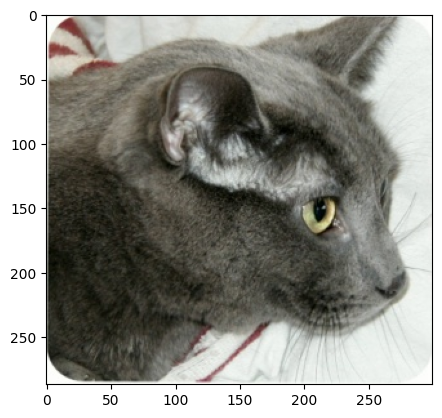

In [46]:
image = keras.utils.load_img(data_dir / "Cat" / "6779.jpg")
plt.imshow(image)

If we wait for a few minutes for our model upload to finish processing on the Kaggle
side, we can go ahead and download the model we just created and use it to classify this
test image.

In [51]:
from keras_hub.models import ImageClassifier

# Correct the username and URL format
model_url = f"kaggle://nabasarodrick/resnet/keras/cats_vs_dogs"

try:
    image_classifier = ImageClassifier.from_preset(model_url)
    result = image_classifier.predict(np.array([image]))
    print("Prediction:", result)
except Exception as e:
    print("Error:", e)


Error: 403 Client Error.

You don't have permission to access resource at URL: https://www.kaggle.com/models/nabasarodrick/resnet/keras/cats_vs_dogs. The server reported the following issues: Permission 'models.get' was denied
Please make sure you are authenticated if you are trying to access a private resource or a resource requiring consent.


Congratulations on uploading your first model with KerasHub! If you want to share your
work with others, you can go to the model link printed out when we uploaded the model, and
turn the model public in settings.

Let's delete this model to free up memory before we move on to our final example for this
guide.

In [ ]:
del image_classifier

## Building a custom text classifier

![](https://storage.googleapis.com/keras-nlp/getting_started_guide/prof_keras_expert.png)

As a final example for this getting started guide, let's take a look at how we can build
custom models from lower-level Keras and KerasHub components. We will build a text
classifier to classify movie reviews in the IMDb dataset as either positive or negative.

Let's download the dataset.

In [ ]:
extract_dir = keras.utils.get_file(
    "imdb_reviews",
    origin="https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz",
    extract=True,
)
data_dir = pathlib.Path(extract_dir) / "aclImdb"

The IMDb dataset contrains a large amount of unlabeled movie reviews. We don't need those
here, we can simply delete them.

In [ ]:
import shutil

shutil.rmtree(data_dir / "train" / "unsup")

Next up, we can load our data with `keras.utils.text_dataset_from_directory`. As with our
image dataset creation above, the returned datasets will be `tf.data.Dataset` objects.

In [ ]:
raw_train_ds = keras.utils.text_dataset_from_directory(
    data_dir / "train",
    batch_size=2,
)
raw_val_ds = keras.utils.text_dataset_from_directory(
    data_dir / "test",
    batch_size=2,
)

KerasHub is designed to be a layered API. At the top-most level, tasks aim to make it
easy to quickly tackle a problem. We could keep using the task API here, and create a
`keras_hub.models.TextClassifer` for a text classification model like BERT, and fine-tune
it in 10 or so lines of code.

Instead, to make our final example a little more interesting, let's show how we can use
lower-level API components to do something that isn't directly baked in to the library.
We will take the Gemma 2 model we used earlier, which is usually used for generating text,
and modify it to output classification predictions.

A common approach for classifying with a generative model would keep using it in a generative
context, by prompting it with the review and a question (`"Is this review positive or negative?"`).
But making an actual classifier is more useful if you want an actual probability score associated
with your labels.

Instead of loading the Gemma 2 model through the `CausalLM` task, we can load two
lower-level components: a **backbone** and a **tokenizer**. Much like the task classes we have
used so far, `keras_hub.models.Backbone` and `keras_hub.tokenizers.Tokenizer` both have a
`from_preset()` constructor for loading pretrained models. If you are running this code,
you will note you don't have to wait for a download as we use the model a second time,
the weights files are cached locally the first time we use the model.

In [ ]:
tokenizer = keras_hub.tokenizers.Tokenizer.from_preset(
    "gemma2_instruct_2b_en",
)
backbone = keras_hub.models.Backbone.from_preset(
    "gemma2_instruct_2b_en",
)

We saw what the tokenizer does in the second example of this guide. We can use it to map
from string inputs to token ids in a way that matches the pretrained weights of the Gemma
model.

The backbone will map from a sequence of token ids to a sequence of embedded tokens in
the latent space of the model. We can use this rich representation to build a classifier.

Let's start by defining a custom preprocessing routine. `keras_hub.layers` contains a
collection of modeling and preprocessing layers, included some layers for token
preprocessing. We can use `keras_hub.layers.StartEndPacker`, which will append a special
start token to the beginning of each review, a special end token to the end, and finally
truncate or pad each review to a fixed length.

If we combine this with our `tokenizer`, we can build a preprocessing function that will
output batches of token ids with shape `(batch_size, sequence_length)`. We should also
output a padding mask that marks which tokens are padding tokens, so we can later exclude
these positions from our Transformer's attention computation. Most Transformer backbones
in KerasNLP take in a `"padding_mask"` input.

In [ ]:
packer = keras_hub.layers.StartEndPacker(
    start_value=tokenizer.start_token_id,
    end_value=tokenizer.end_token_id,
    pad_value=tokenizer.pad_token_id,
    sequence_length=None,
)


def preprocess(x, y=None, sequence_length=256):
    x = tokenizer(x)
    x = packer(x, sequence_length=sequence_length)
    x = {
        "token_ids": x,
        "padding_mask": x != tokenizer.pad_token_id,
    }
    return keras.utils.pack_x_y_sample_weight(x, y)


With our preprocessing defined, we can simply use `tf.data.Dataset.map` to apply our
preprocessing to our input data.

In [ ]:
train_ds = raw_train_ds.map(preprocess, num_parallel_calls=16)
val_ds = raw_val_ds.map(preprocess, num_parallel_calls=16)
next(iter(train_ds))

Running fine-tuning on a 2.5 billion parameter model is quite expensive compared to the
image classifier we trained earlier, for the simple reason that this model is 100x the
size of ResNet! To speed things up a bit, let's reduce the size of our training data to a
tenth of the original size. Of course, this is leaving some performance on the table
compared to full training, but it will keep things running quickly for our guide.

In [ ]:
train_ds = train_ds.take(1000)
val_ds = val_ds.take(1000)

Next, we need to attach a classification head to our backbone model. In general, text
transformer backbones will output a tensor with shape
`(batch_size, sequence_length, hidden_dim)`. The main thing we will need to
classify with this input is to pool on the sequence dimension so we have a single
feature vector per input example.

Since the Gemma model is a generative model, information only passed from left to right
in the sequence. The only token representation that can "see" the entire movie review
input is the final token in each review. We can write a simple pooling layer to do this —
we will simply grab the last non-padding position of each input sequence. There's no special
process to writing a layer like this, we can use Keras and `keras.ops` normally.

In [ ]:
from keras import ops


class LastTokenPooler(keras.layers.Layer):
    def call(self, inputs, padding_mask):
        end_positions = ops.sum(padding_mask, axis=1, keepdims=True) - 1
        end_positions = ops.cast(end_positions, "int")[:, :, None]
        outputs = ops.take_along_axis(inputs, end_positions, axis=1)
        return ops.squeeze(outputs, axis=1)


With this pooling layer, we are ready to write our Gemma classifier. All task and backbone
models in KerasHub are [functional](https://keras.io/guides/functional_api/) models, so
we can easily manipulate the model structure. We will call our backbone on our inputs, add
our new pooling layer, and finally add a small feedforward network with a `"relu"` activation
in the middle. Let's try it out.

In [ ]:
inputs = backbone.input
x = backbone(inputs)
x = LastTokenPooler(
    name="pooler",
)(x, inputs["padding_mask"])
x = keras.layers.Dense(
    2048,
    activation="relu",
    name="pooled_dense",
)(x)
x = keras.layers.Dropout(
    0.1,
    name="output_dropout",
)(x)
outputs = keras.layers.Dense(
    2,
    activation="softmax",
    name="output_dense",
)(x)
text_classifier = keras.Model(inputs, outputs)
text_classifier.summary()

Before we train, there is one last trick we should employ to make this code run on free
tier colab GPUs. We can see from our model summary our model takes up almost 10 gigabytes
of space. An optimizer will need to make multiple copies of each parameter during
training, taking the total space of our model during training close to 30 or 40
gigabytes.

This would OOM many GPUs. A useful trick we can employ is to enable LoRA on our
backbone. LoRA is an approach which freezes the entire model, and only trains a low-parameter
decomposition of large weight matrices. You can read more about LoRA in this [Keras
example](https://keras.io/examples/nlp/parameter_efficient_finetuning_of_gpt2_with_lora/).
Let's try enabling it and re-printing our summary.

In [ ]:
backbone.enable_lora(4)
text_classifier.summary()

After enabling LoRA, our model goes from 10GB of traininable parameters to just 20MB.
That means the space used by optimizer variables will no longer be a concern.

With all that set up, we can compile and train our model as normal.

In [ ]:
text_classifier.compile(
    optimizer=keras.optimizers.Adam(5e-5),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)
text_classifier.fit(
    train_ds,
    validation_data=val_ds,
)

We are able to achieve over ~93% accuracy on the movie review sentiment
classification problem. This is not bad, given that we only used a 10th of our
original dataset to train.

Taken together, the `backbone` and `tokenizer` we created in this example
allowed us access the full power of pretrained Gemma checkpoints, without
restricting what we could do with them. This is a central aim of the KerasHub
API. Simple workflows should be easy, and as you go deeper, you gain access to a
deeply customizable set of building blocks.

## Going further

This is just scratching the surface of what you can do with the KerasHub.

This guide shows a few of the high-level tasks that we ship with the KerasHub library,
but there are many tasks we did not cover here. Try [generating images with Stable
Diffusion](https://keras.io/guides/keras_hub/stable_diffusion_3_in_keras_hub/), for
example.

The most significant advantage of KerasHub is it gives you the flexibility to combine pre-trained
building blocks with the full power of Keras 3. You can train large LLMs on TPUs with model
parallelism with the [keras.distribution](https://keras.io/guides/distribution/) API. You can
quantize models with Keras' [quatize
method](https://keras.io/examples/keras_recipes/float8_training_and_inference_with_transfo
rmer/). You can write custom training loops and even mix in direct Jax, Torch, or
Tensorflow calls.

See [keras.io/keras_hub](https://keras.io/keras_hub/) for a full list of guides and
examples to continue digging into the library.